# Analysis of My Apple Music Library

In [57]:
import numpy as np
import pandas as pd
import requests
import json
import networkx as nx
import os
import dotenv
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import streamlit as st # dashboarding?
import lyricsgenius # a wrapper around requests that works specifically with the Genius API
sys.tracebacklimit = 0 # turn off the error tracebacks

In [4]:
# load data from csv/json files
dailyPlay = pd.read_csv('AppleMusicData/Apple Music - Play History Daily Tracks.csv')
topContent = pd.read_csv('AppleMusicData/Apple Music - Top Content.csv')
favs = pd.read_csv('AppleMusicData/Apple Music - Favorites.csv')
libraryTracks = pd.read_json('AppleMusicData/Apple Music Library Tracks.json')
libraryTracks = libraryTracks.drop(columns=['Sort Composer'])

/var/folders/yt/vc06mr81367d93jqy5fmf0c40000gn/T/ipykernel_5149/2192444282.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dailyPlay = pd.read_csv('AppleMusicData/Apple Music - Play History Daily Tracks.csv')


In [5]:
#
print(favs['Favorite Type'].unique())
favs = favs[favs['Favorite Type'] != 'Unknown']
favAlbums = favs[favs['Favorite Type'] == 'Album']
favSongs = favs[favs['Favorite Type'] == 'Song']
favPlaylists = favs[favs['Favorite Type'] == 'Playlist']
favArtists =  favs[favs['Favorite Type'] == 'Artist']

['Artist' 'Song' 'Unknown' 'Playlist' 'Album']


In [6]:
#Look at media type column and look for na values in dailyPlay
print(dailyPlay['Media type'].unique())
print(dailyPlay['Ignore For Recommendations'].unique())
print(dailyPlay['Ignore For Recommendations'] == True)
for colunm in dailyPlay.columns:
    print(colunm, dailyPlay[colunm].isna().sum())

[nan 'AUDIO' 'VIDEO']
[nan False True]
0         False
1         False
2         False
3         False
4         False
          ...  
248521    False
248522    False
248523    False
248524    False
248525    False
Name: Ignore For Recommendations, Length: 248526, dtype: bool
Country 0
Track Identifier 0
Media type 5640
Date Played 0
Hours 0
Play Duration Milliseconds 0
End Reason Type 0
Source Type 0
Play Count 0
Skip Count 0
Ignore For Recommendations 5840
Track Reference 14507
Track Description 17


In [7]:
dailyPlay[dailyPlay['Media type'] == 'VIDEO'].value_counts()
dailyPlay[dailyPlay['Track Description'].isna()]
dailyPlayCleaned = dailyPlay[~((dailyPlay['Media type'] == 'VIDEO') & (dailyPlay['Track Description'].isna()))]
dailyPlayCleaned = dailyPlay.drop(columns=['Ignore For Recommendations',  'Track Reference'])
dailyPlayCleaned['Media type'].fillna('AUDIO', inplace=True)
dailyPlayCleaned['Date Played'] = pd.to_datetime(dailyPlayCleaned['Date Played'], format='%Y%m%d')

/var/folders/yt/vc06mr81367d93jqy5fmf0c40000gn/T/ipykernel_5149/217504134.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dailyPlayCleaned['Media type'].fillna('AUDIO', inplace=True)


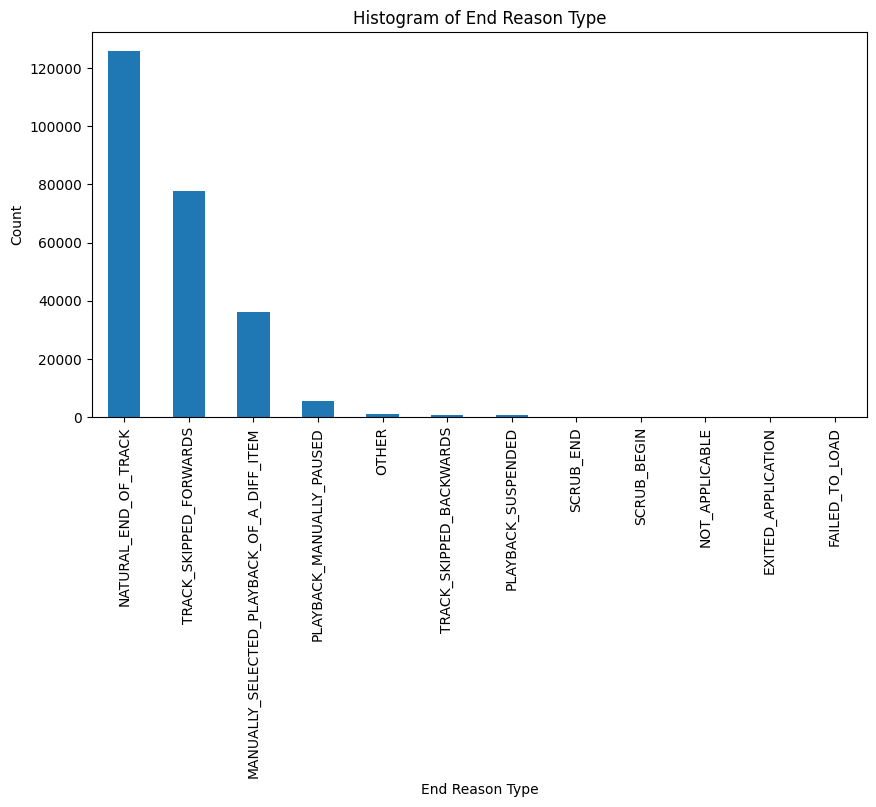

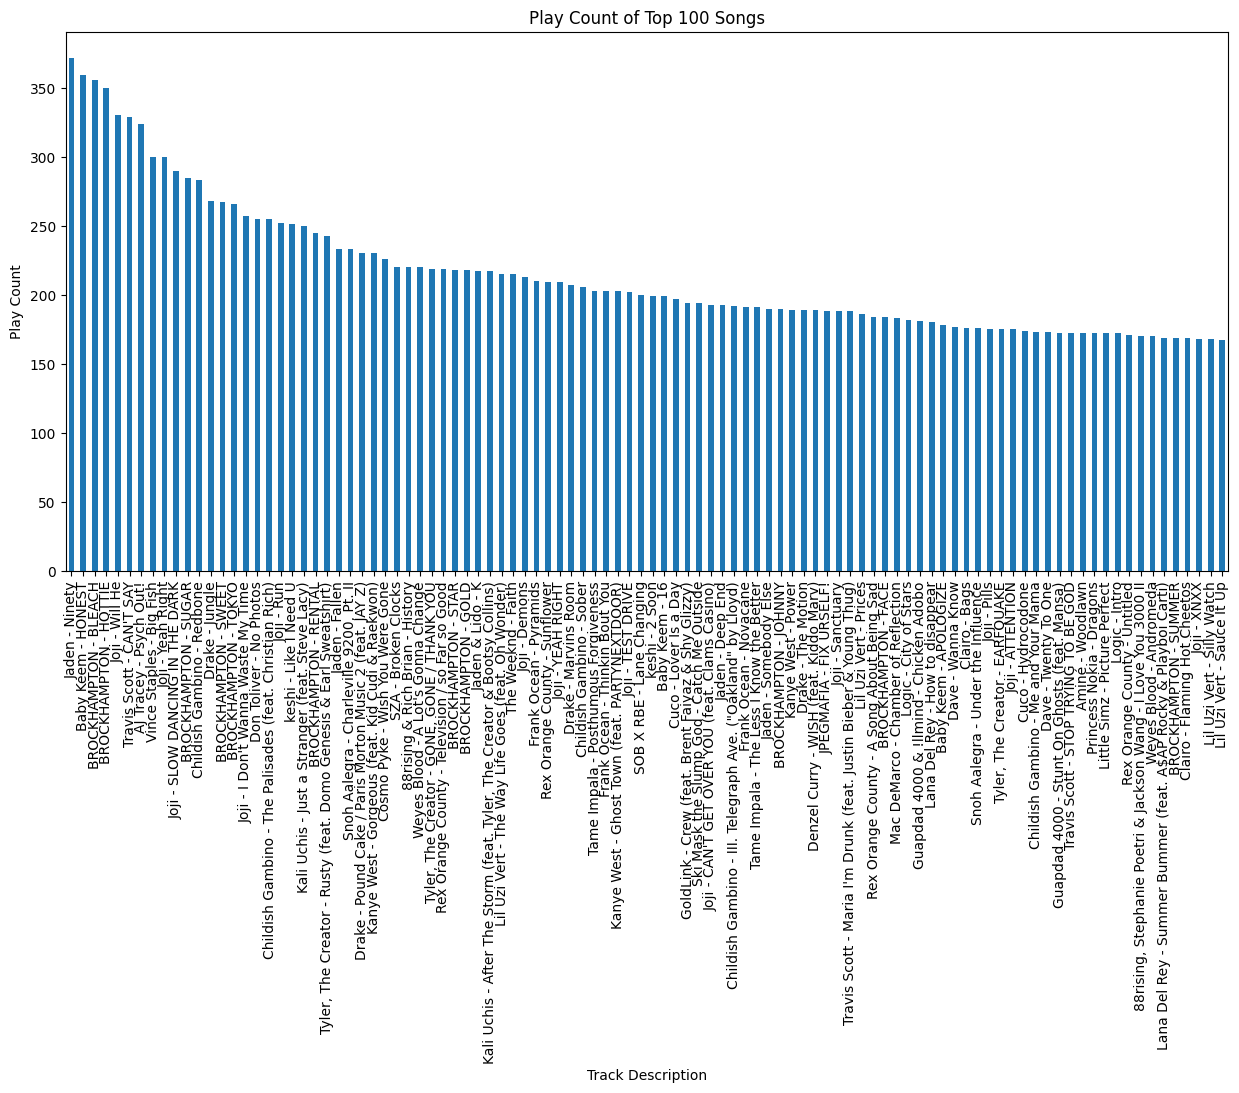

In [8]:
#look at the distribution of "End Reason Type" to determine the most frequent way a song ended
dailyPlayCleaned# Histogram of "End Reason Type"
plt.figure(figsize=(10, 5))
dailyPlayCleaned['End Reason Type'].value_counts().plot(kind='bar')
plt.title('Histogram of End Reason Type')
plt.xlabel('End Reason Type')
plt.ylabel('Count')
plt.show()

top_100_songs = dailyPlayCleaned['Track Description'].value_counts().head(100)

# Plot the graph of top 100 songs in dailyPlayCleaned
plt.figure(figsize=(15, 7))
top_100_songs.plot(kind='bar')
plt.title('Play Count of Top 100 Songs')
plt.xlabel('Track Description')
plt.ylabel('Play Count')
plt.xticks(rotation=90)
plt.show()


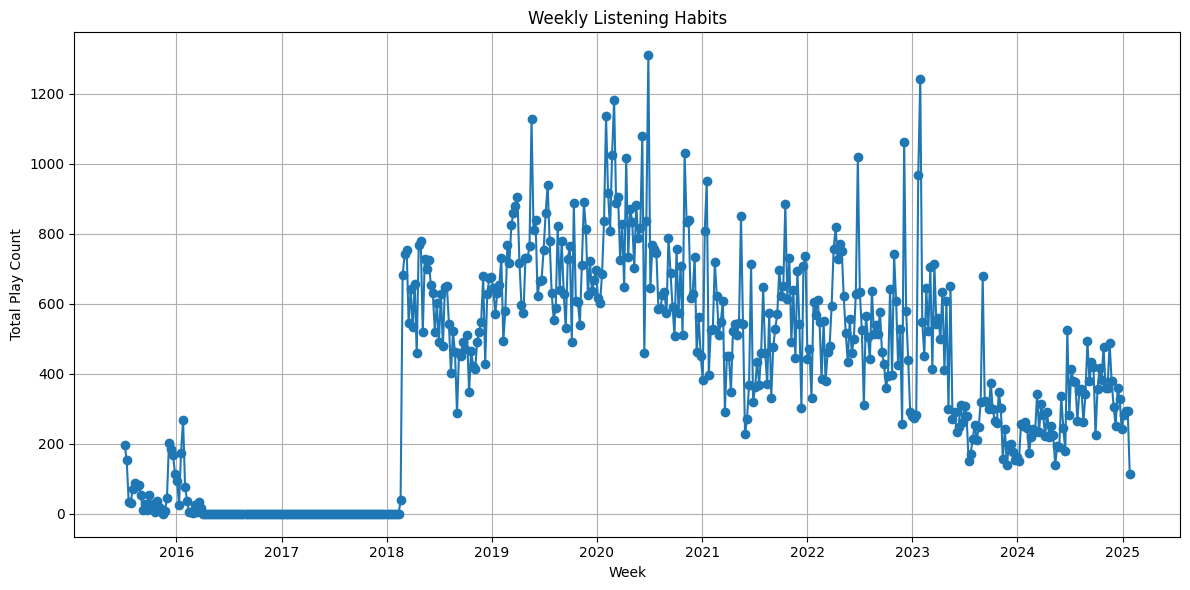

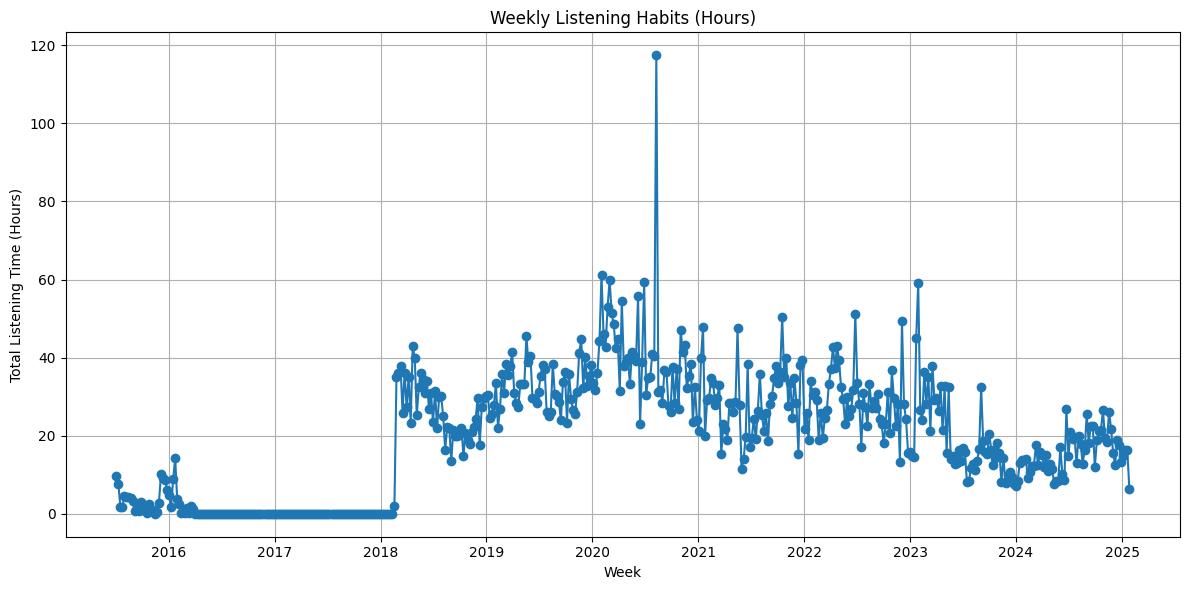

In [9]:
# Ensure 'Date Played' is in datetime format
dailyPlayCleaned['Date Played'] = pd.to_datetime(dailyPlayCleaned['Date Played'])

# Group by week and sum the play counts
weekly_plays = (dailyPlayCleaned
                .groupby(pd.Grouper(key='Date Played', freq='W'))['Play Count']
                .sum()
                .reset_index())

# Plotting weekly listening habits by play count
plt.figure(figsize=(12, 6))
plt.plot(weekly_plays['Date Played'], weekly_plays['Play Count'], marker='o', linestyle='-')
plt.title('Weekly Listening Habits')
plt.xlabel('Week')
plt.ylabel('Total Play Count')
plt.grid(True)
plt.tight_layout()
plt.show()

# Group by week and sum the play durations (converted to hours)
weekly_duration = (dailyPlayCleaned
                   .groupby(pd.Grouper(key='Date Played', freq='W'))['Play Duration Milliseconds']
                   .sum()
                   .reset_index())

# Convert milliseconds to hours
weekly_duration['Play Duration Hours'] = weekly_duration['Play Duration Milliseconds'] / (1000 * 60 * 60)

# Plotting weekly listening habits by play duration
plt.figure(figsize=(12, 6))
plt.plot(weekly_duration['Date Played'], weekly_duration['Play Duration Hours'], marker='o', linestyle='-')
plt.title('Weekly Listening Habits (Hours)')
plt.xlabel('Week')
plt.ylabel('Total Listening Time (Hours)')
plt.grid(True)
plt.tight_layout()
plt.show()


Apple Music Started June 30, 2015 I had the app and used it primarily for the free music stations. Sometime in early 2016 I switched from iPhone to Samsung and with it from Apple Music to Spotify. In 2018 I switched back and subscribed to the streaming service. This explains the big jump between the pre-spotify days and the post-spotify days.

In [10]:
# look at earliest full listen of a song
dailyPlayCleaned[(dailyPlayCleaned['Track Description'] == 'BROCKHAMPTON - HOTTIE') & (dailyPlayCleaned['End Reason Type'] == 'NATURAL_END_OF_TRACK')].head(15)

,Country,Track Identifier,Media type,Date Played,Hours,Play Duration Milliseconds,End Reason Type,Source Type,Play Count,Skip Count,Track Description
11399,United States,1322094235,AUDIO,2018-04-26,"2, 11, 12, 18, 19",646607,NATURAL_END_OF_TRACK,IPHONE,6,1,BROCKHAMPTON - HOTTIE
11523,United States,1322094235,AUDIO,2018-04-27,"4, 21",394414,NATURAL_END_OF_TRACK,IPHONE,2,0,BROCKHAMPTON - HOTTIE
11706,United States,1322094235,AUDIO,2018-04-28,17,197207,NATURAL_END_OF_TRACK,IPHONE,1,0,BROCKHAMPTON - HOTTIE
11803,United States,1322094235,AUDIO,2018-04-29,2,197207,NATURAL_END_OF_TRACK,IPHONE,1,0,BROCKHAMPTON - HOTTIE
11963,United States,1322094235,AUDIO,2018-05-02,"3, 12, 15",489724,NATURAL_END_OF_TRACK,IPHONE,3,0,BROCKHAMPTON - HOTTIE
12188,United States,1322094235,AUDIO,2018-05-04,18,197207,NATURAL_END_OF_TRACK,IPHONE,2,0,BROCKHAMPTON - HOTTIE
12234,United States,1322094235,AUDIO,2018-05-05,3,197207,NATURAL_END_OF_TRACK,IPHONE,1,0,BROCKHAMPTON - HOTTIE
12307,United States,1322094235,AUDIO,2018-05-07,"11, 12",197207,NATURAL_END_OF_TRACK,IPHONE,1,1,BROCKHAMPTON - HOTTIE
12400,United States,1322094235,AUDIO,2018-05-08,13,191782,NATURAL_END_OF_TRACK,IPHONE,1,0,BROCKHAMPTON - HOTTIE
12495,United States,1322094235,AUDIO,2018-05-09,"18, 19",394414,NATURAL_END_OF_TRACK,IPHONE,2,0,BROCKHAMPTON - HOTTIE


In [28]:
#Check for missing values in libraryTracks
for colunm in libraryTracks.columns:
    print(colunm, libraryTracks[colunm].isna().sum())

Content Type 0
Track Identifier 0
Title 0
Sort Name 782
Artist 20
Sort Artist 854
Composer 1680
Is Part of Compilation 28
Album 47
Sort Album 834
Album Artist 289
Genre 35
Grouping 10505
Comments 10284
Track Year 9
Track Number On Album 19
Track Count On Album 19
Disc Number Of Album 40
Disc Count Of Album 19
Beats Per Minute 10542
Track Duration 6
Track Play Count 0
Date Added To Library 0
Date Added To iCloud Music Library 0
Last Modified Date 0
Last Played Date 2182
Purchase Date 11622
Rating 8808
Album Rating 8807
Skip Count 0
Date of Last Skip 6436
Is Purchased 0
Audio File Extension 3
Remember Playback Position 10165
Album Like Rating 8628
Track Like Rating 10404
Album Rating Method 8916
Is Checked 0
Work Name 10541
Movement Name 10553
Movement Number 10553
Movement Count 10553
Release Date 930
Display Work Name 10169
Purchased Track Identifier 861
Audio Matched Track Identifier 11640
Tag Matched Track Identifier 8486
Apple Music Track Identifier 724
Favorite Status - Track 11703

In [ ]:
# Dropping irrelevant columns
libraryTracksCleaned = libraryTracks.drop(columns=['Audio Matched Track Identifier', 'Grouping', 'Comments', 'Disc Number Of Album', 'Disc Number Of Album', 
                                                   'Purchase Date', 'Rating', 'Beats Per Minute', 'Album Like Rating', 'Track Like Rating', 'Work Name', 'Movement Name', 
                                                   'Movement Number', 'Movement Count', 'Display Work Name', 'Purchased Track Identifier','Audio Matched Track Identifier',
                                                   'Tag Matched Track Identifier','Apple Music Track Identifier', 'Favorite Status - Track','Favorite Date - Track',
                                                   'Favorite Date - Track', 'Favorite Status - Album', 'Playlist Only Track','Favorite Status - Album', 'Sort Album Artist',
                                                   'Track Like Rating', 'Album Like Rating','Remember Playback Position', 'Album Rating', 'Album Rating Method', 'Composer', 
                                                   'Copyright', 'Is Part of Compilation','Date of Last Skip','Last Played Date', 'Track Number On Album', 'Track Count On Album',
                                                   'Disc Count Of Album', 'Release Date'])

In [49]:
for colunm in libraryTracksCleaned.columns:
    print(colunm, libraryTracksCleaned[colunm].isna().sum())
#libraryTracksCleaned[libraryTracksCleaned['Track Year'].isna()]
libraryTracksCleaned['Track Year'].fillna(2025, inplace=True)


Content Type 0
Track Identifier 0
Title 0
Sort Name 782
Artist 20
Sort Artist 854
Album 47
Sort Album 834
Album Artist 289
Genre 35
Track Year 0
Track Duration 6
Track Play Count 0
Date Added To Library 0
Date Added To iCloud Music Library 0
Last Modified Date 0
Skip Count 0
Is Purchased 0
Audio File Extension 0
Is Checked 0


/var/folders/yt/vc06mr81367d93jqy5fmf0c40000gn/T/ipykernel_5149/1681433597.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  libraryTracksCleaned['Track Year'].fillna(2025, inplace=True)


In [51]:
#Cleaning Artist Name NaNs
# Condition to filter rows where the title matches
condition = libraryTracksCleaned['Title'] == 'Got This Money (Acoustic @ Ace Hotel)'
condition2 = libraryTracksCleaned['Title'].str.startswith('BabyTron -')
condition3 = (libraryTracksCleaned['Album'].isna()) & (libraryTracksCleaned['Sort Album'].isna()) & (libraryTracksCleaned['Artist'] == 'Childish Gambino')
condition4 = (libraryTracksCleaned['Album'].isna()) & (libraryTracksCleaned['Sort Album'].isna()) & (libraryTracksCleaned['Artist'].str.startswith('Internet Money'))
# Fill NaN values in "Sort Name" and "Artist" columns with "Childish Gambino"
libraryTracksCleaned.loc[condition, 'Sort Artist'] = libraryTracksCleaned.loc[condition, 'Sort Artist'].fillna('Childish Gambino')
libraryTracksCleaned.loc[condition, 'Artist'] = libraryTracksCleaned.loc[condition, 'Artist'].fillna('Childish Gambino')
libraryTracksCleaned.loc[condition2, 'Sort Artist'] = libraryTracksCleaned.loc[condition2, 'Sort Artist'].fillna('BabyTron')
libraryTracksCleaned.loc[condition2, 'Artist'] = libraryTracksCleaned.loc[condition2, 'Artist'].fillna('BabyTron')
libraryTracksCleaned = libraryTracksCleaned.dropna(subset=['Sort Name', 'Artist', 'Album'], how='all')
libraryTracksCleaned['Sort Name'].fillna(libraryTracksCleaned['Title'], inplace=True)
libraryTracksCleaned['Sort Album'].fillna(libraryTracksCleaned['Album'], inplace=True)
libraryTracksCleaned['Sort Artist'].fillna(libraryTracksCleaned['Artist'], inplace=True)
libraryTracksCleaned['Album Artist'].fillna(libraryTracksCleaned['Sort Artist'], inplace=True)
libraryTracksCleaned['Album Artist'].fillna(libraryTracksCleaned['Sort Artist'], inplace=True)
libraryTracksCleaned.loc[condition3, 'Album'] = 'Culdesac'
libraryTracksCleaned.loc[condition3, 'Sort Album'] = 'Culdesac'
libraryTracksCleaned.loc[condition4, 'Album'] = 'B4 the Storm'
libraryTracksCleaned.loc[condition4, 'Sort Album'] = 'B4 the Storm'
libraryTracksCleaned['Album'].fillna(libraryTracksCleaned['Title'], inplace=True)
libraryTracksCleaned['Sort Album'].fillna(libraryTracksCleaned['Title'], inplace=True)
#libraryTracksCleaned.loc[condition3, 'Album Artist'] = libraryTracksCleaned.loc[condition3, 'Album Artist'].fillna('Internet Money')


/var/folders/yt/vc06mr81367d93jqy5fmf0c40000gn/T/ipykernel_5149/2270599452.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  libraryTracksCleaned['Sort Name'].fillna(libraryTracksCleaned['Title'], inplace=True)
/var/folders/yt/vc06mr81367d93jqy5fmf0c40000gn/T/ipykernel_5149/2270599452.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate objec

In [ ]:
#inputting missing values for "Audio File Extension" column
print(libraryTracksCleaned['Audio File Extension'].unique())
libraryTracksCleaned['Audio File Extension'].fillna('mp3', inplace=True)
libraryTracksCleaned[libraryTracksCleaned['Audio File Extension'].isna()]

['m4a' 'mp3' 'm4v']


/var/folders/yt/vc06mr81367d93jqy5fmf0c40000gn/T/ipykernel_5149/3108929237.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  libraryTracksCleaned['Audio File Extension'].fillna('mp3', inplace=True)


,Content Type,Track Identifier,Title,Sort Name,Artist,Sort Artist,Album,Sort Album,Album Artist,Genre,Track Year,Track Duration,Track Play Count,Date Added To Library,Date Added To iCloud Music Library,Last Modified Date,Skip Count,Is Purchased,Audio File Extension,Is Checked


In [ ]:
#inputting missing values for "Genre" column
libraryTracksCleaned['Genre'].unique
libraryTracksCleaned['Genre'].fillna('Hip-Hop/Rap', inplace=True)
libraryTracksCleaned[libraryTracksCleaned['Genre'].isna()] 

/var/folders/yt/vc06mr81367d93jqy5fmf0c40000gn/T/ipykernel_5149/871483712.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  libraryTracksCleaned['Genre'].fillna('Hip-Hop/Rap', inplace=True)


,Content Type,Track Identifier,Title,Sort Name,Artist,Sort Artist,Album,Sort Album,Album Artist,Genre,Track Year,Track Duration,Track Play Count,Date Added To Library,Date Added To iCloud Music Library,Last Modified Date,Skip Count,Is Purchased,Audio File Extension,Is Checked


In [ ]:
#inputting missing values for "Track Duration" column 
# MIssing tracks had tracks with the same title, so I filled the missing values with the mean of the track duration of the tracks with the same title
libraryTracksCleaned['Track Duration'] = libraryTracksCleaned.groupby('Title')['Track Duration'].transform(lambda x: x.fillna(x.mean()))
for colunm in libraryTracksCleaned.columns:
    print(colunm, libraryTracksCleaned[colunm].isna().sum())

Content Type 0
Track Identifier 0
Title 0
Sort Name 0
Artist 0
Sort Artist 0
Album 0
Sort Album 0
Album Artist 0
Genre 0
Track Year 0
Track Duration 0
Track Play Count 0
Date Added To Library 0
Date Added To iCloud Music Library 0
Last Modified Date 0
Skip Count 0
Is Purchased 0
Audio File Extension 0
Is Checked 0


The Shannon diversity index calculator is a tool which helps you to estimate the diversity of species within a community. Here we are using it to measure the diversity of the categorical variables: Artists, Genre, & Album in my library

Shannon Diversity Index (Artist): 5.632022629864142
Shannon Diversity Index (Genre): 1.3105310036306101
Shannon Diversity Index (Album): 6.899357542464289


/var/folders/yt/vc06mr81367d93jqy5fmf0c40000gn/T/ipykernel_5149/413007059.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_diversity = libraryTracksCleaned.groupby(pd.Grouper(key='Date Added To Library', freq='M'))


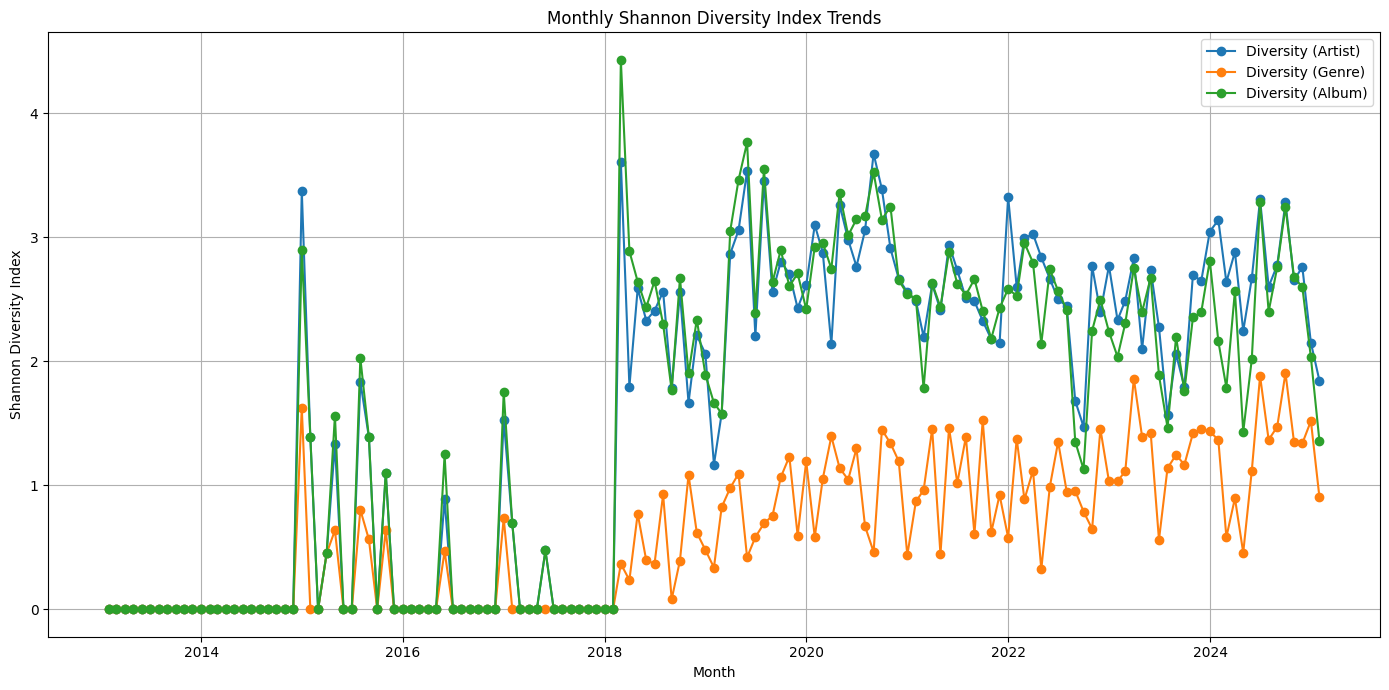

In [ ]:
from scipy.stats import entropy
categories = ['Artist', 'Genre', 'Album']
diversity_indices = {}

for category in categories:
    counts = libraryTracksCleaned[category].value_counts()
    diversity_indices[category] = entropy(counts)

# Print diversity indices
for category, index in diversity_indices.items():
    print(f"Shannon Diversity Index ({category}): {index}")

# Visualize diversity trends over time (monthly)
libraryTracksCleaned['Date Added To Library'] = pd.to_datetime(libraryTracksCleaned['Date Added To Library'])

monthly_diversity = libraryTracksCleaned.groupby(pd.Grouper(key='Date Added To Library', freq='M'))

# Calculate monthly diversity for each category
monthly_diversity_indices = {category: [] for category in categories}
dates = []

for date, group in monthly_diversity:
    dates.append(date)
    for category in categories:
        counts = group[category].value_counts()
        index = entropy(counts)
        monthly_diversity_indices[category].append(index)

# Plotting diversity trends
plt.figure(figsize=(14, 7))
for category in categories:
    plt.plot(dates, monthly_diversity_indices[category], marker='o', label=f'Diversity ({category})')

plt.title('Monthly Shannon Diversity Index Trends')
plt.xlabel('Month')
plt.ylabel('Shannon Diversity Index')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The Shannon Diversity Index (H') typically ranges from 0 to ln(S), where S is the total number of unique categories (e.g., unique artists, genres, or albums) 

Shannon Diversity Index (Genre): 1.3105310036306101
Shows that a few genres take up a large proportion of the library (Could this have been more easily seen with a percent of songs in genre?(probably))

Shannon Diversity Index (Artist): 5.632022629864142

Shannon Diversity Index (Album): 6.899357542464289
For Artist & Album, shows highly diverse Artist and Album libraries. My library contains a wide array of artists.

ChatGPT: For comparison, a library with 100 equally played artists would have a maximum index of ln(100) ≈ 4.61. Your 5.63 implies both a large number of artists and fairly balanced play counts.

Changes in diversity might be cause by Album drops from my favorite artists. When Kendrick Lamar drops a Hip-Hop Album since it is my most listened to genre diversity decreases. On the other end when Post Malone dropped his Country album F1-Trillion diversity increased. Multiple drops in the same month of Hip-hop or Alternative vs any other genre could greatly swing diversity metrics.

In [70]:
dailyPlayCleaned['Date Played'].dtypes

dtype('<M8[ns]')

In [76]:
pd.set_option('display.max_rows', 15) # display only 15 rows
# Ensure 'Date Played' is in datetime format
dailyPlayCleaned['Date Played'] = pd.to_datetime(dailyPlayCleaned['Date Played'], errors='coerce')
dailyPlayCleaned['Month'] = dailyPlayCleaned['Date Played'].dt.to_period('M')
dailyPlayCleaned[['Artist', 'Title']] = dailyPlayCleaned['Track Description'].str.split(' - ', n=1, expand=True)
# Personalized Insights
# Most played song/artist each month
top_songs_monthly = dailyPlayCleaned.groupby(['Month', 'Title'])['Play Count'].sum().reset_index()
top_songs_monthly = top_songs_monthly.loc[top_songs_monthly.groupby('Month')['Play Count'].idxmax()]
print("Most Played Song Each Month:\n", top_songs_monthly)

top_artists_monthly = dailyPlayCleaned.groupby(['Month', 'Artist'])['Play Count'].sum().reset_index()
top_artists_monthly = top_artists_monthly.loc[top_artists_monthly.groupby('Month')['Play Count'].idxmax()]
print("Most Played Artist Each Month:\n", top_artists_monthly)

# Songs you’ve outgrown: High play counts in the past but none recently
past_songs = dailyPlayCleaned[dailyPlayCleaned['Date Played'] < '2024-01-01'].groupby('Title')['Play Count'].sum()
recent_songs = dailyPlayCleaned[dailyPlayCleaned['Date Played'] >= '2024-01-01']['Title'].unique()
outgrown_songs = past_songs[~past_songs.index.isin(recent_songs)]
print("Songs You’ve Outgrown:\n", outgrown_songs)

# Longest listening streaks
dailyPlayCleaned['Consecutive'] = dailyPlayCleaned['Date Played'].diff().dt.days.eq(1).cumsum()
longest_streak = dailyPlayCleaned.groupby('Consecutive')['Date Played'].count().max()
print(f"Longest Listening Streak: {longest_streak} days")

Most Played Song Each Month:
           Month                                     Title  Play Count
271     2015-07                                     Power          36
535     2015-08  Truffle Butter (feat. Drake & Lil Wayne)          84
603     2015-09                             Know Yourself          17
648     2015-10                        Can't Feel My Face          17
667     2015-11                                   Berzerk          10
...         ...                                       ...         ...
116378  2024-09                                         V          24
116710  2024-10                                    Bodies          14
118250  2024-11                    First Love/Late Spring          13
119807  2024-12                                       Sin          12
120316  2025-01                    First Love/Late Spring           9

[93 rows x 3 columns]
Most Played Artist Each Month:
          Month              Artist  Play Count
137    2015-07          Kany

([0], [Text(0, 0, 'First Love/Late Spring')])

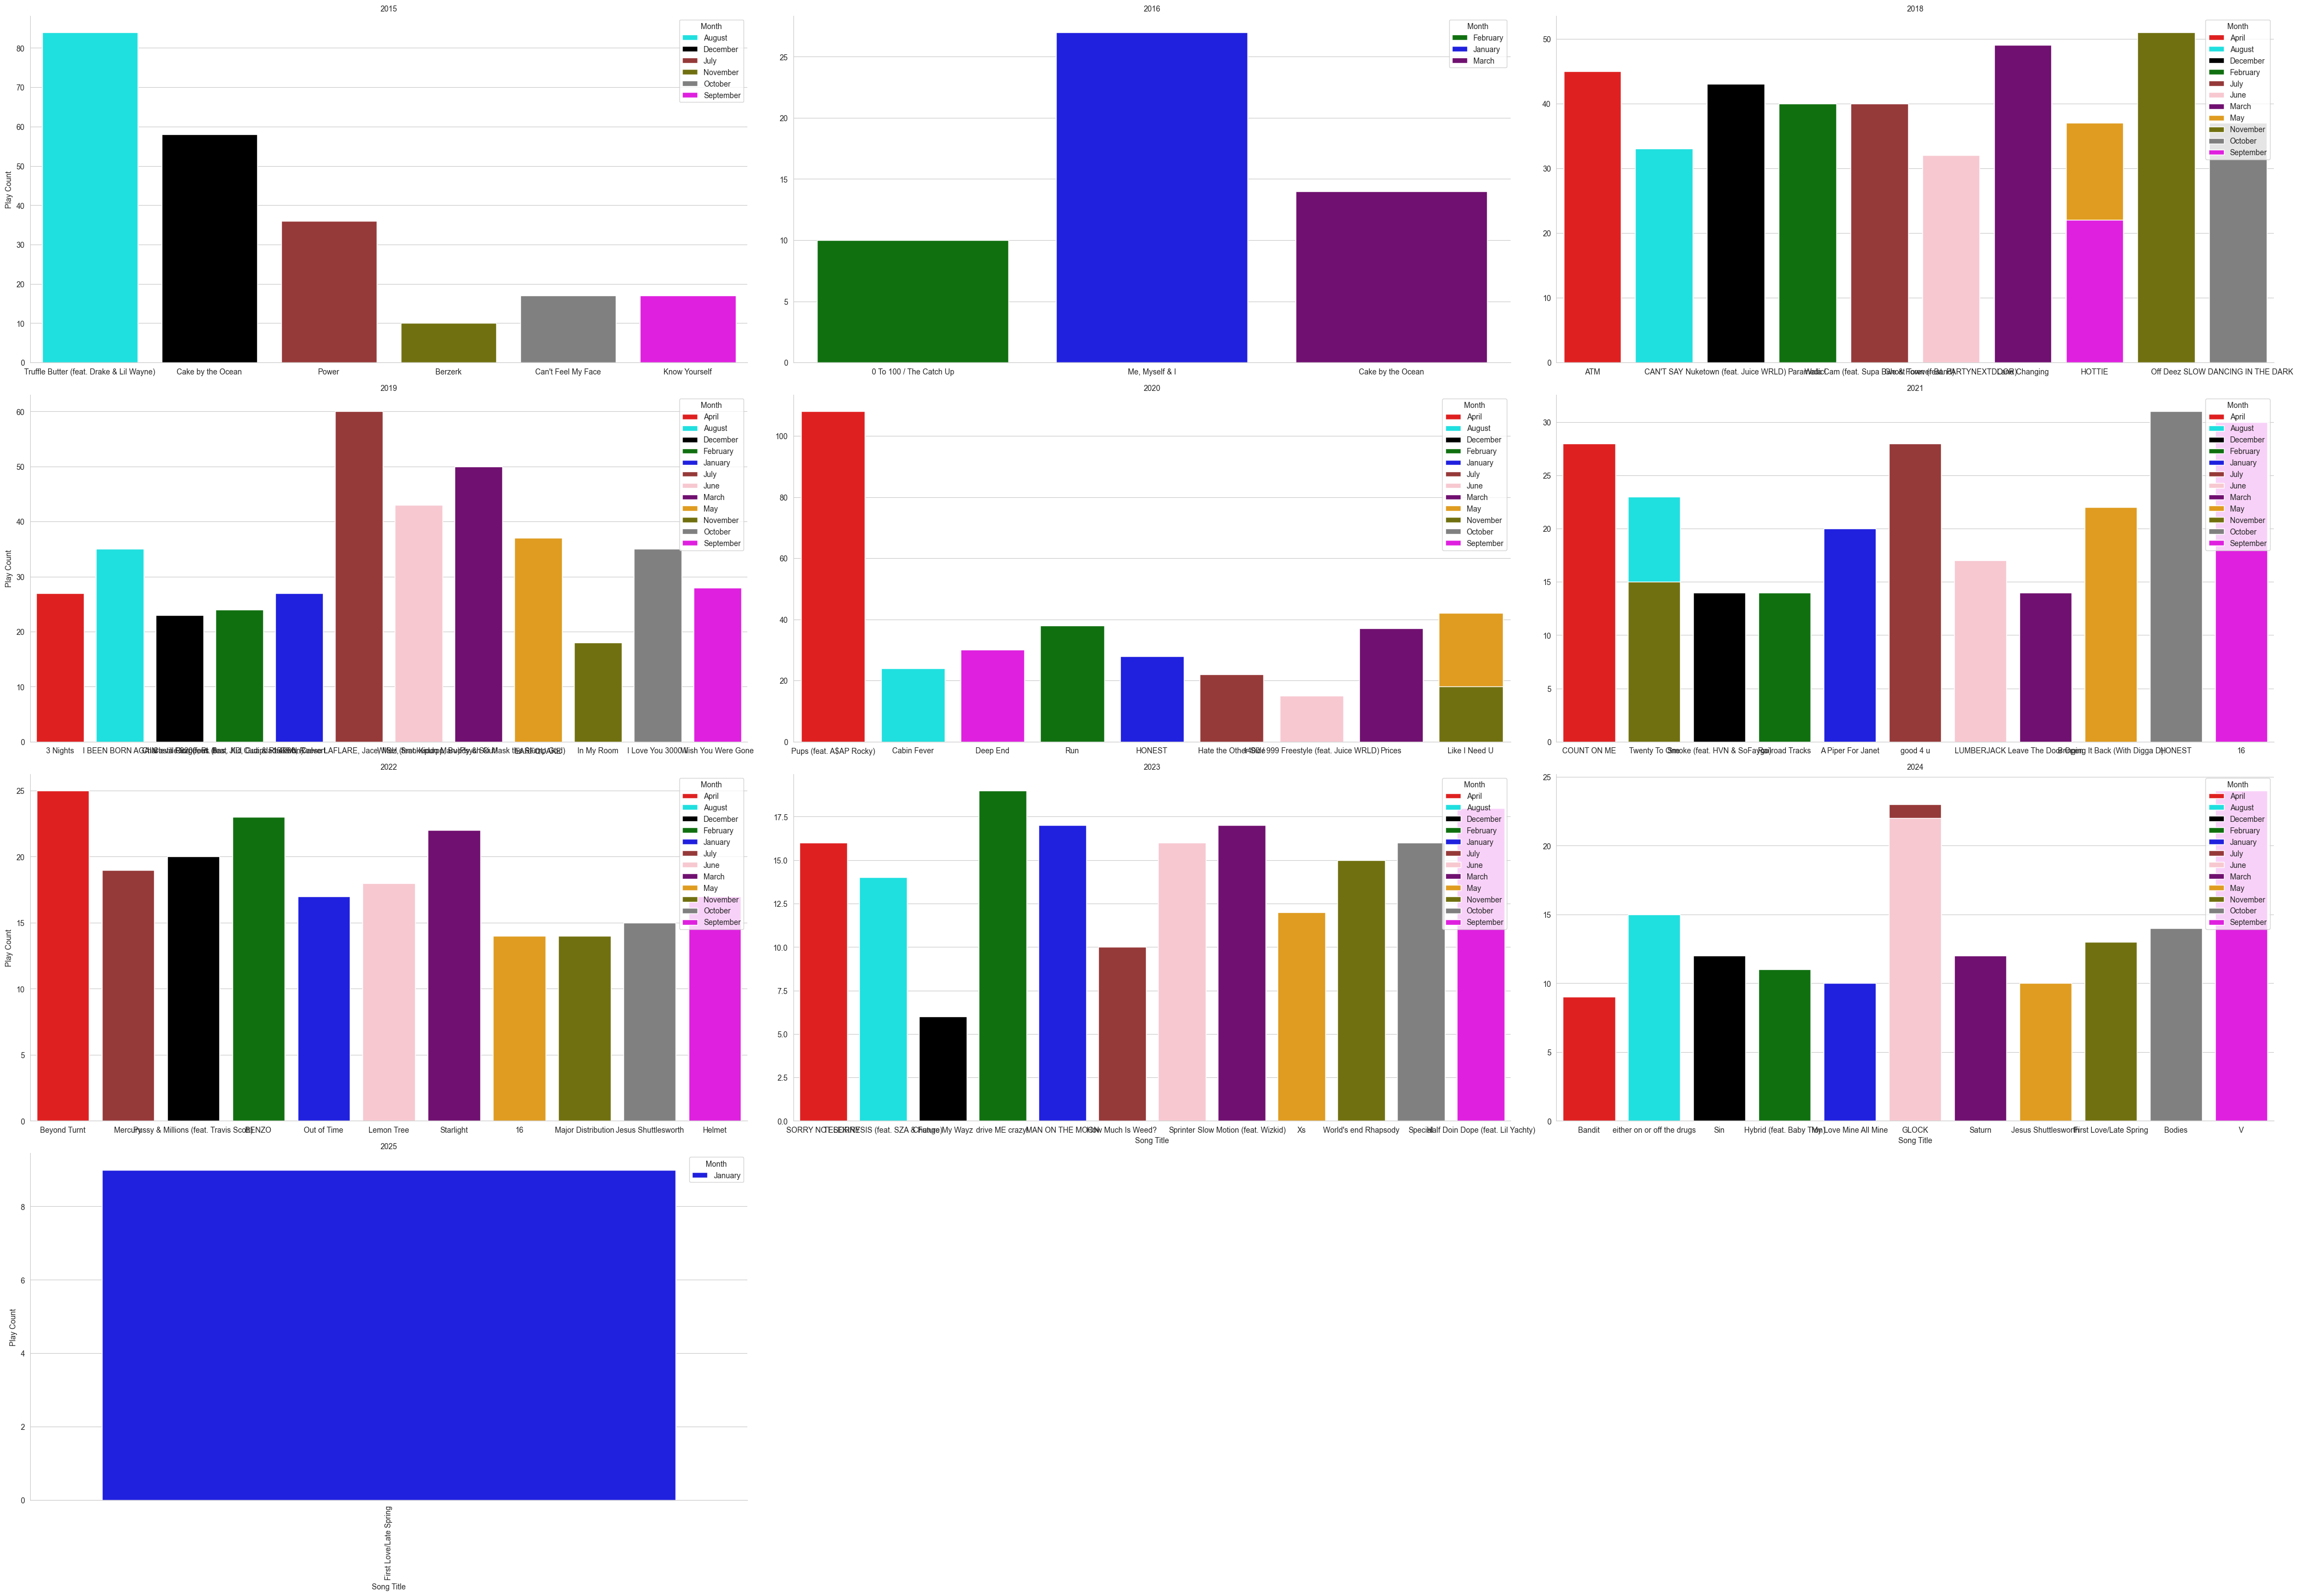

In [83]:
dailyPlayCleaned['Year'] = dailyPlayCleaned['Date Played'].dt.year
dailyPlayCleaned['Month Name'] = dailyPlayCleaned['Date Played'].dt.strftime('%B')

# Define colors for each month
month_colors = {
    'January': 'blue', 'February': 'green', 'March': 'purple', 'April': 'red',
    'May': 'orange', 'June': 'pink', 'July': 'brown', 'August': 'cyan',
    'September': 'magenta', 'October': 'gray', 'November': 'olive', 'December': 'black'
}

# Get top songs each month
top_songs_monthly = dailyPlayCleaned.groupby(['Year', 'Month Name', 'Title'])['Play Count'].sum().reset_index()
top_songs_monthly = top_songs_monthly.loc[top_songs_monthly.groupby(['Year', 'Month Name'])['Play Count'].idxmax()]

# Plot with FacetGrid
sns.set_style('whitegrid')
g = sns.FacetGrid(top_songs_monthly, col='Year', col_wrap=3, height=7, aspect=2,sharex=False, sharey=False)
g.map_dataframe(sns.barplot, x='Title', y='Play Count', hue='Month Name', palette=month_colors, dodge=False)

g.set_axis_labels("Song Title", "Play Count")
g.set_titles(col_template="{col_name}")

# Move legends inside each subplot
for ax in g.axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right', title='Month')

plt.xticks(rotation=90)
plt.show()

([0], [Text(0, 0, 'Tyler, The Creator')])

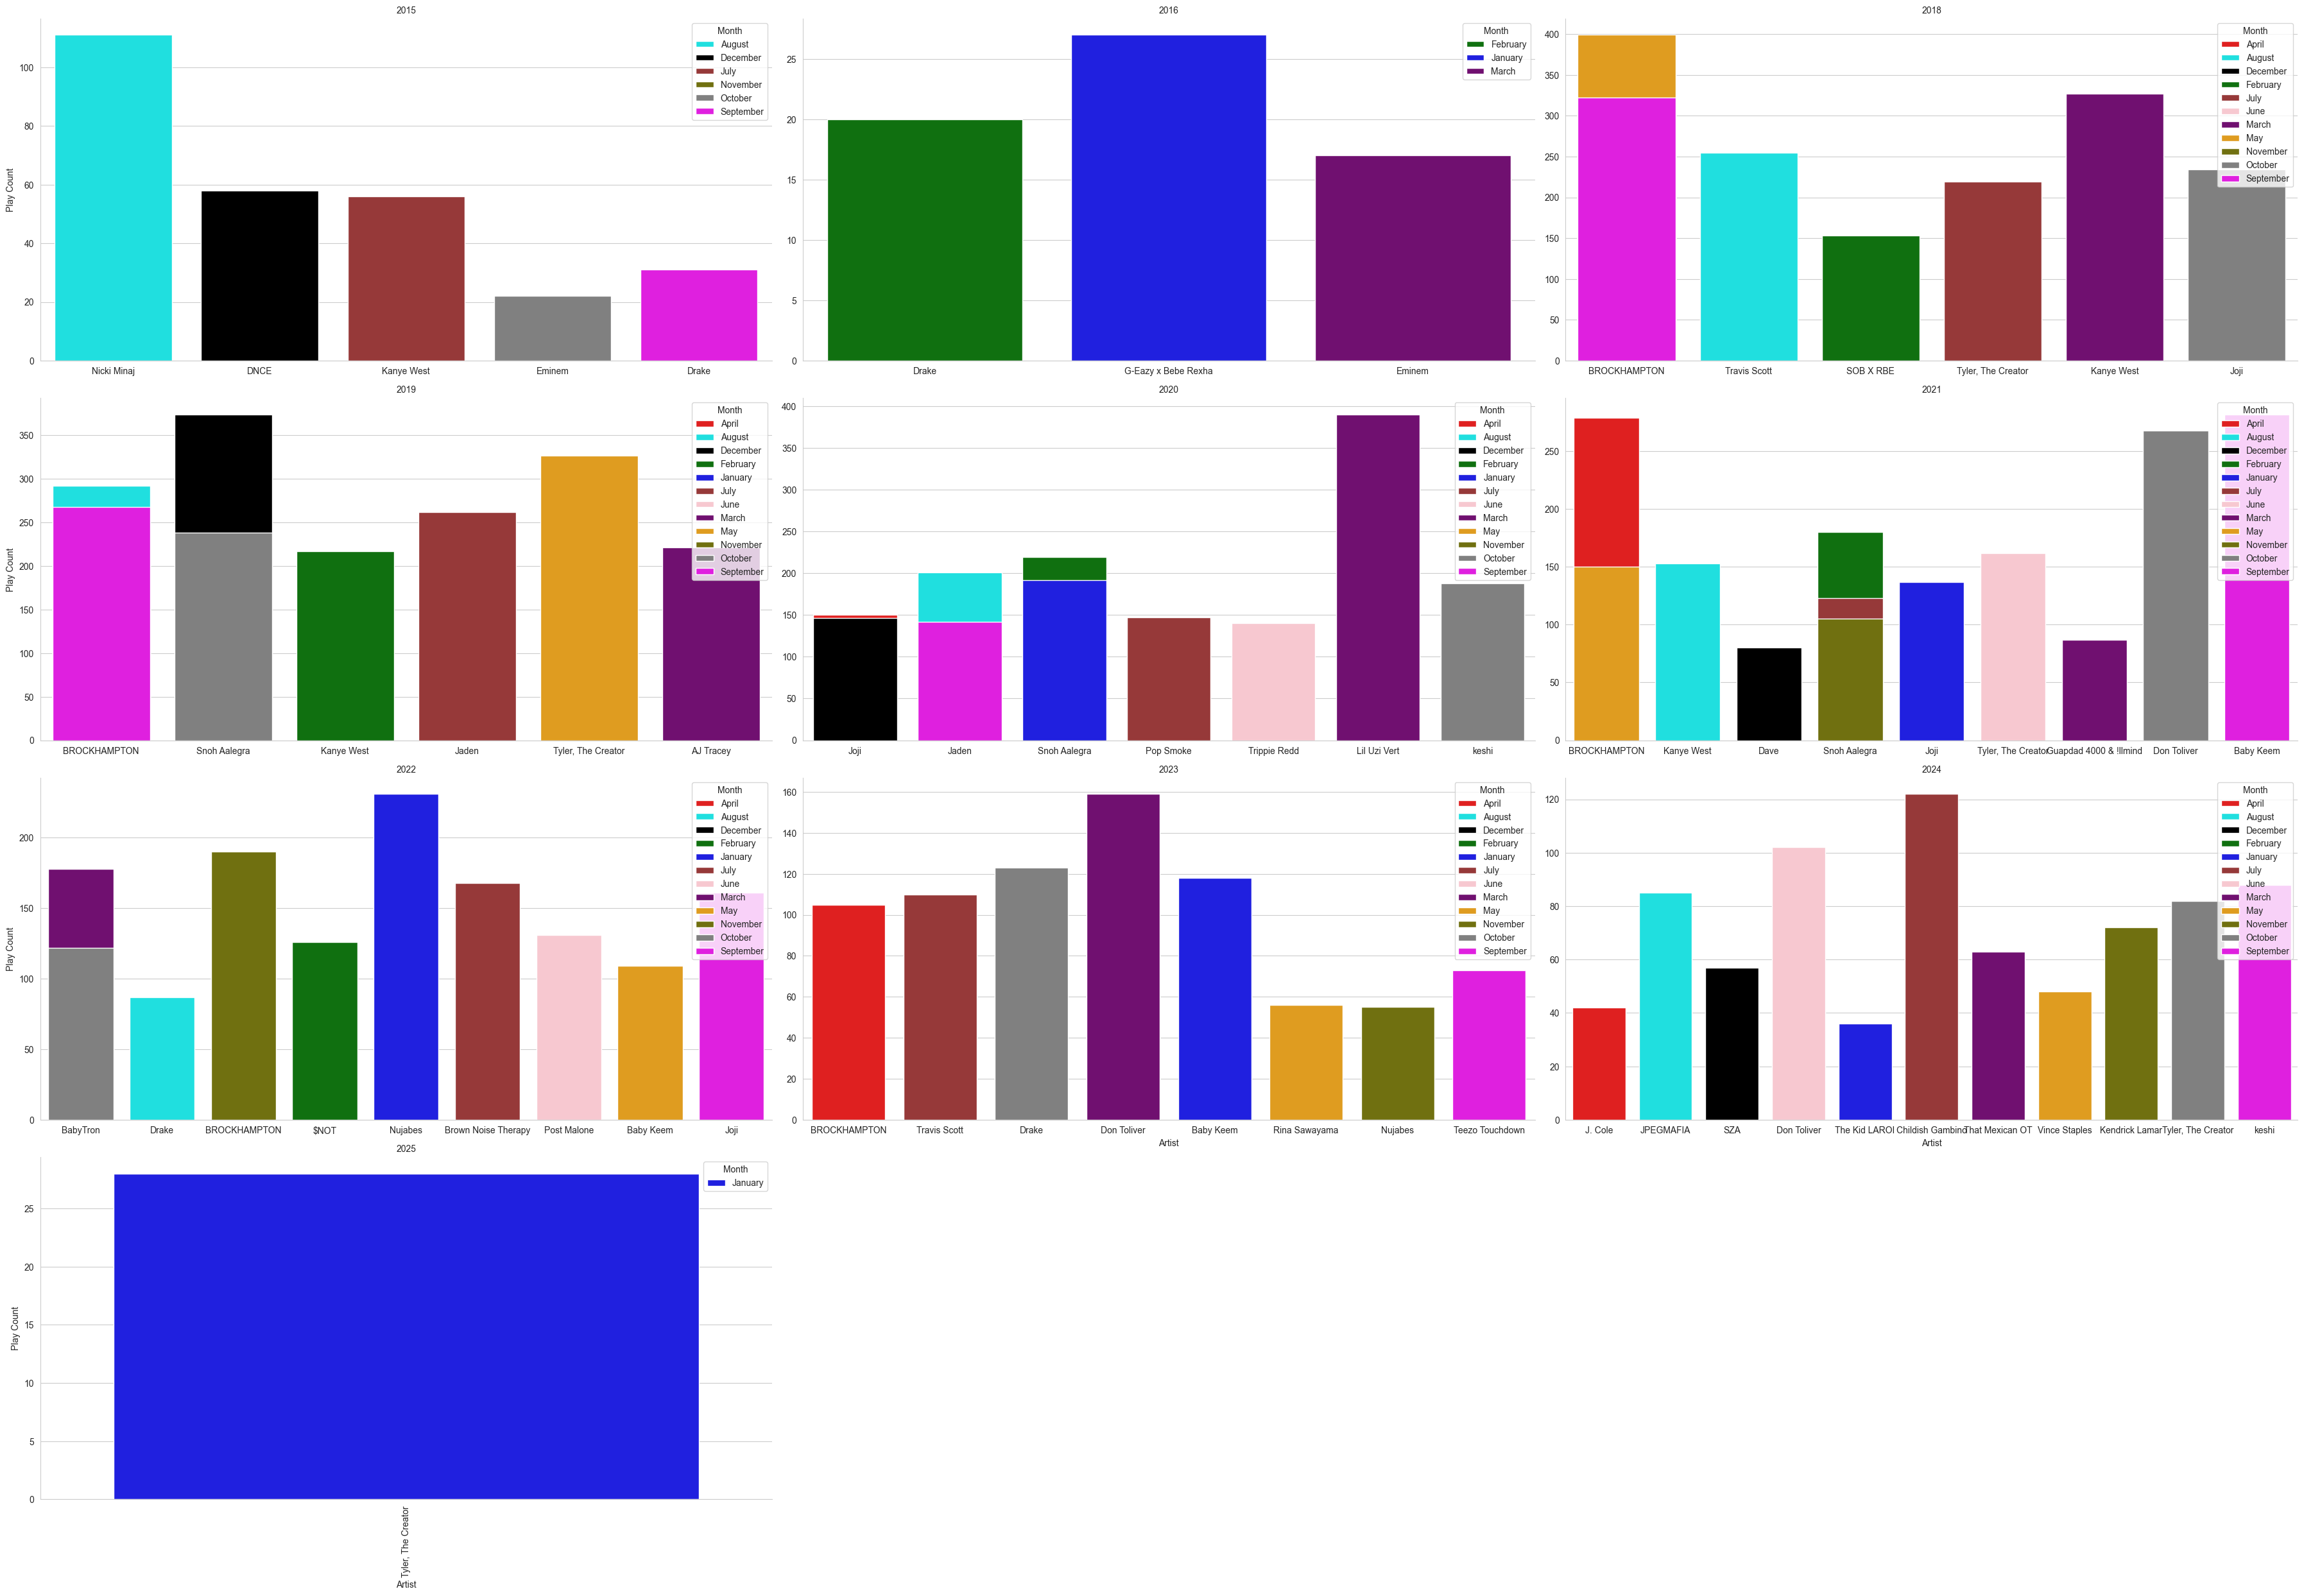

In [89]:
top_artists_monthly = dailyPlayCleaned.groupby(['Year', 'Month Name', 'Artist'])['Play Count'].sum().reset_index()
top_artists_monthly = top_artists_monthly.loc[top_artists_monthly.groupby(['Year', 'Month Name'])['Play Count'].idxmax()]

# Plot with FacetGrid
sns.set_style('whitegrid')
g = sns.FacetGrid(top_artists_monthly, col='Year', col_wrap=3, height=6, aspect=2, sharex=False, sharey=False)
g.map_dataframe(sns.barplot, x='Artist', y='Play Count', hue='Month Name', palette=month_colors, dodge=False)

g.set_axis_labels("Artist", "Play Count")
g.set_titles(col_template="{col_name}")

# Move legends inside each subplot
for ax in g.axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right', title='Month')

plt.xticks(rotation=90)
plt.show()